In [324]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import ModelFramework as mf
import sympy as sym
import numpy as np
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

## Generate Parameters Structure

In [325]:
b_shapes = 3
p = mf.ModelParameters.DynamicModel(b_shapes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 1,string = 'c') # chord of wing
p.s = mf.ModelSymbol(value = 3,string = 's') # total semi-span of wing
p.rho = mf.ModelSymbol(value = 5,string = 'rho') # per per unit area (kg/m^2)

## Create the addtional mass
p.m_1 = mf.ModelSymbol(value = 1, string = 'm_1')

## damping factor
p.sigma = mf.ModelSymbol(value = 0.05, string = 'sigma')
p.g = mf.ModelSymbol(value = 9.81, string = 'g')
p.tip_deflection = mf.ModelSymbol(value = 1, string='mu')

# Wing stiffness Properties
p.f_0 = mf.ModelSymbol(value = 2,string='f_0')
p.EI = mf.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing


p.y_i = mf.ModelSymbol(value = 0,string='y_i')

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

# Factor to change the size of joint values
p.eta = mf.ModelMatrix(value = [1]*(b_shapes),symbols=sym.symbols(f'eta:{p.qs}'))

## Generate Elements

In [326]:
#get shape functions for main wing
z_0,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q,p.y_0,p.x_0,0,0,factor=p.eta)
z_t = z_0.subs(p.y_0,p.s)

d2z_dy2 = z_0.diff(p.y_0,p.y_0).subs(p.y_0,p.y_i)
grad_func = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_func = sym.lambdify((p.GetTuple(),p.q),z_0.subs(p.y_0,p.y_i))

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform()
tip_frame = wing_root_frame.Translate(0,p.s,z_t)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho)

tip_ele = ele.RigidElement.PointMass(tip_frame,p.m_1,gravityPotential=True)
wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s,0,p.EI,0,gravityPot=True)

In [327]:
z_0.subs(p.y_0,p.y_i)

y_i**4*eta2*q2(t) + y_i**3*eta1*q1(t) + y_i**2*eta0*q0(t)

## Generate external forces

In [328]:
force = ef.ExternalForce(p.qd*-1*p.sigma)

## Generate Model

In [329]:
sm = mf.SymbolicModel.FromElementsAndForces(p,[wing_ele,tip_ele],force)
sm.to_file('tester.py')
sm = mf.SymbolicModel.from_file('tester.py')
nm = sm.CreateNumericModel(p)

## Get Initial Conditions

For a given tip deflection need to find the shape of the wing.

Use the principle that the correct shape has the minimium P.E

In [330]:
z_0

eta0*y_0**2*q0(t) + eta1*y_0**3*q1(t) + eta2*y_0**4*q2(t)

In [347]:
## Get values for eta by assuming a unit deflection
from scipy.optimize import minimize
p.s.value = 3
p.tip_deflection.value = p.s.value*0.1
p.eta.value = [1]*p.qs
p.EI.value = (2*np.pi*p.f_0.value/3.516)**2*p.rho.value*p.s.value**4

con_func = sym.lambdify((p.GetTuple(),p.q),z_t-p.tip_deflection.value)
obj_func = sym.lambdify((p.GetTuple(),p.q),wing_ele.CalcElasticPE(p))

tup = p.GetNumericTuple([0]*p.qs*2,0)

con = lambda q:con_func(tup,q)
obj = lambda q:obj_func(tup,q)

cons = ({'type':'eq','fun':con})

Q0 = [0]*p.qs
Q0[0] = p.tip_deflection.value/p.s.value**2

con_func(tup,Q0)

res = minimize(obj,Q0,method='SLSQP',constraints=cons,options={'ftol':1e-6})
print(res.x)
    
Q0 = res.x
#p.eta.value = [p.eta.value[i]*res.x[i]/1000 for i in range(p.qs)]

[ 4.99987410e-02 -5.55469895e-03 -1.45642098e-07]


In [348]:
from scipy.optimize import minimize
p.tip_deflection.value = -p.s.value*0.1

tup = p.GetNumericTuple([0]*p.qs*2,0)

con = lambda q:con_func(tup,q)
obj = lambda q:obj_func(tup,q)

cons = ({'type':'eq','fun':con})


#Q0 = [p.tip_deflection.value]*p.qs
Q0 = [0]*p.qs
Q0[0] = p.tip_deflection.value# p.tip_deflection.value/(p.eta.value[0]*p.s.value**2)

res = minimize(obj,Q0,method='SLSQP',constraints=cons)

Q0 = -res.x
Q0

array([-4.99982790e-02,  5.55438835e-03,  1.97846988e-07])

In [349]:
nm = sm.CreateNumericModel(p)
X0 = [0]*p.qs*2
X0[::2] = Q0
print(X0)
nm.deriv(0,X0,p.GetNumericTuple(X0,0))

[-0.049998278991856264, 0, 0.005554388345210177, 0, 1.9784698804508737e-07, 0]


(0, 111.16142216388153, 0, -126.72036241776141, 0, 32.69929246778668)

In [350]:
p.eta.value

[1, 1, 1]

In [351]:
from scipy.integrate import solve_ivp
nm = sm.CreateNumericModel(p)
p.sigma.value = 50
p.m_1.value = 0
def objectiveDeriv(t,y):
    return nm.deriv(t,y,p.GetNumericTuple(y,t))
X0 = [0]*p.qs*2
X0[::2] = Q0
print(X0)

masses = [0,3,6,9,12,15]

Data= []
for i in masses:
    p.m_1.value = i
    Data.append(solve_ivp(objectiveDeriv,(0,2),X0))

[-0.049998278991856264, 0, 0.005554388345210177, 0, 1.9784698804508737e-07, 0]


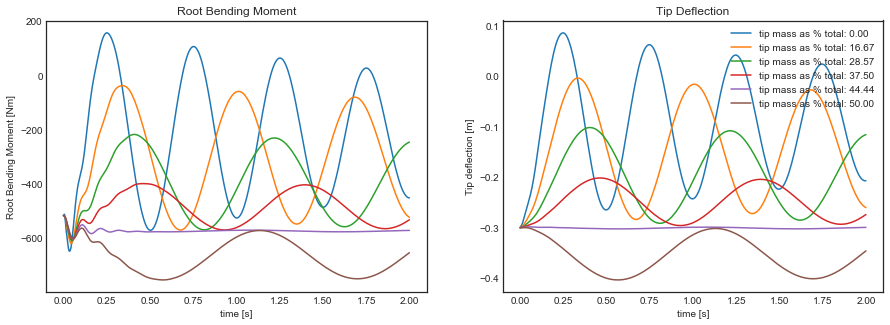

In [352]:
#plot tip deflection and Root bending moment
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

p.y_i.value = 0
tup = p.GetNumericTuple([0]*p.qs*2,0)
root_b = grad_func(tup,yi[::2,:])

p.y_i.value = p.s.value
tup = p.GetNumericTuple([0]*p.qs*2,0)
tip_d = z_func(tup,yi[::2,:])

fig, axes = plt.subplots(1,2,figsize=(15,5))

for i in range(len(masses)):
    yi = Data[i].y
    t=Data[i].t
    
    p.y_i.value = 0
    tup = p.GetNumericTuple([0]*p.qs*2,0)
    root_b = grad_func(tup,yi[::2,:])
    
    axes[0].plot(t,root_b*p.EI.value)
    axes[0].set_title('Root Bending Moment')
    axes[0].set_ylabel('Root Bending Moment [Nm]')
    axes[0].set_xlabel('time [s]')
    
    p.y_i.value = p.s.value
    tup = p.GetNumericTuple([0]*p.qs*2,0)
    tip_d = z_func(tup,yi[::2,:])
    
    axes[1].plot(t,tip_d)
    axes[1].set_title('Tip Deflection')
    
    
axes[0].set_ylabel('Root Bending Moment [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].set_ylabel('Tip deflection [m]')
axes[1].set_xlabel('time [s]')
axes[1].legend([f'tip mass as % total: {i*100/(15+i):.2f}' for i in masses])